# La influencia de la cesta de la compra
Anton Hurtado - Problema Individual Lista 4

## Cargamos librerías necesarias

In [1]:
# Uncomment to upgrade packages
# !pip install pandas --user --upgrade --quiet
# !pip install numpy --user --upgrade --quiet
# !pip install scipy --user --upgrade --quiet
# !pip install statsmodels --user --upgrade --quiet
# !pip install seaborn --user --upgrade --quiet
# !pip install matplotlib --user --upgrade --quiet
# !pip install scikit-learn --user --upgrade
!pip install imblearn --upgrade --user --quiet
!pip install scikit-optimize --user --quiet
!pip install dtreeviz --upgrade --user --quiet
!pip install apafib --upgrade --user --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [13]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                    classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from apafib import load_BCN_cesta

from skopt import BayesSearchCV
np.int = int # fix for skopt

from numpy.random import choice
from sklearn.inspection import permutation_importance

from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, make_scorer

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [14]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

## Apartado A

In [2]:
data = load_BCN_cesta()
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Carn / Pollastre,365.0,1.073,0.127,0.85,0.96,1.11,1.18,1.24
Carn / Porcí,365.0,1.254,0.183,1.02,1.10,1.23,1.46,1.55
Fruites i hortalisses / Ceba,365.0,0.318,0.106,0.24,0.25,0.30,0.32,1.00
Fruites i hortalisses / Patata,365.0,0.409,0.059,0.34,0.35,0.40,0.45,0.65
Fruites i hortalisses / Plàtan,365.0,1.385,0.307,0.90,1.20,1.25,1.70,2.00
Fruites i hortalisses / Poma,365.0,0.951,0.217,0.70,0.80,0.90,1.00,1.60
Fruites i hortalisses / Taronja,365.0,0.965,0.207,0.60,0.80,0.90,1.10,1.75
Peix i marisc / Llenguado,365.0,13.772,2.111,8.50,12.80,13.90,15.00,19.00
Peix i marisc / Llobarro,365.0,5.054,0.354,4.50,4.80,5.00,5.40,5.95
Peix i marisc / Lluç,365.0,4.302,1.080,1.80,3.50,4.00,5.00,7.50


In [3]:
data = data.rename(columns={'Indicador de reserves hoteleres internacionals (base = mitjana suavitzada gener/febrer 2020) / Barcelona':'Indicador de reserves hoteleres'})

X = data.loc[:,data.columns!='Indicador de reserves hoteleres']
y = data.loc[:,'Indicador de reserves hoteleres']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=42)

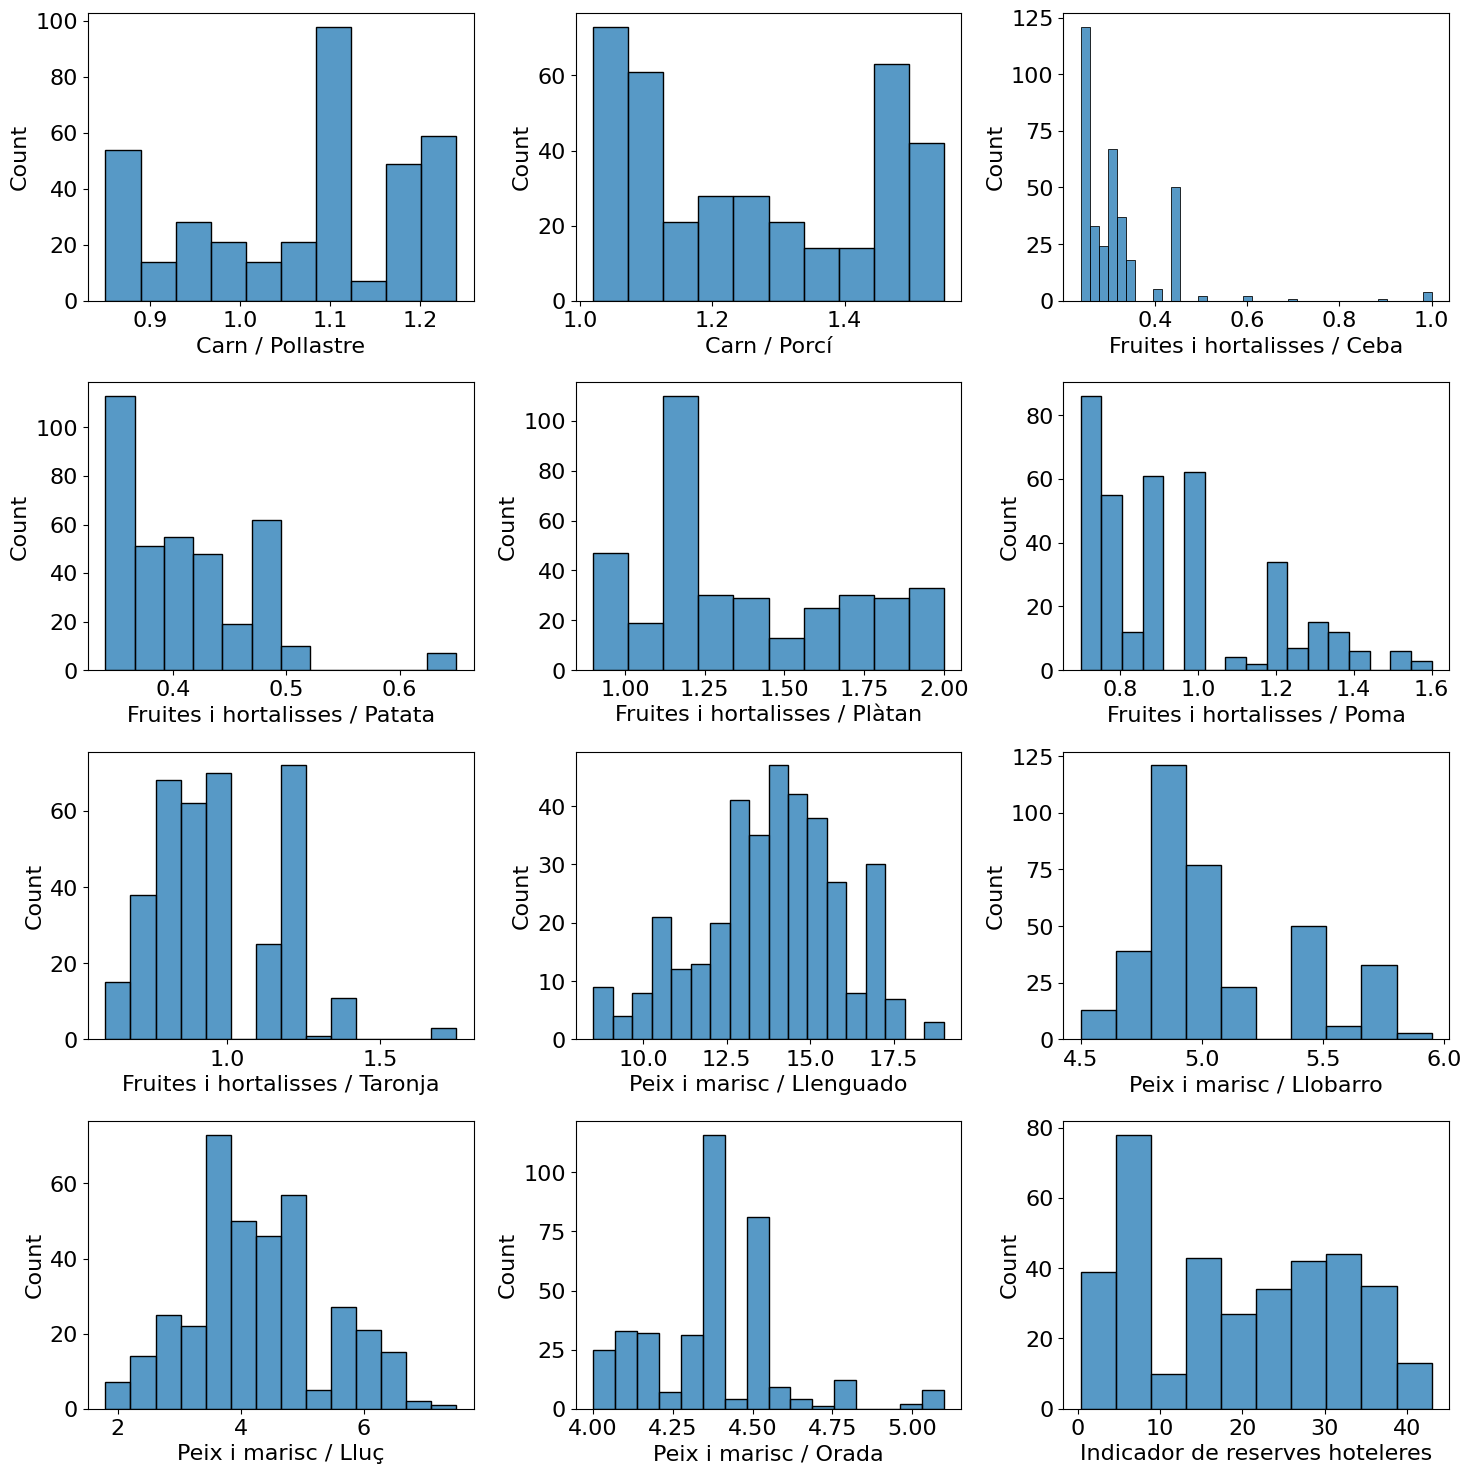

In [6]:
fig, axes = plt.subplots(4,3,figsize=(15,15))
data_frame = pd.DataFrame(data)
data_frame.columns=data.columns
for i, c in enumerate(data.columns):
    ax = axes.reshape(-1)[i]
    if data_frame[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=data_frame,ax=ax)
    else:
        b = sns.histplot(x=c,data=data_frame,ax=ax)
plt.tight_layout()

De las siguientes gráficas podemos ver que la categoría de pescado y marisco es la que tiene los precios más elevados, con un máximo de casi 20 € por el lenguado; mientras que el resto de categorías tienen un precio muy similar.

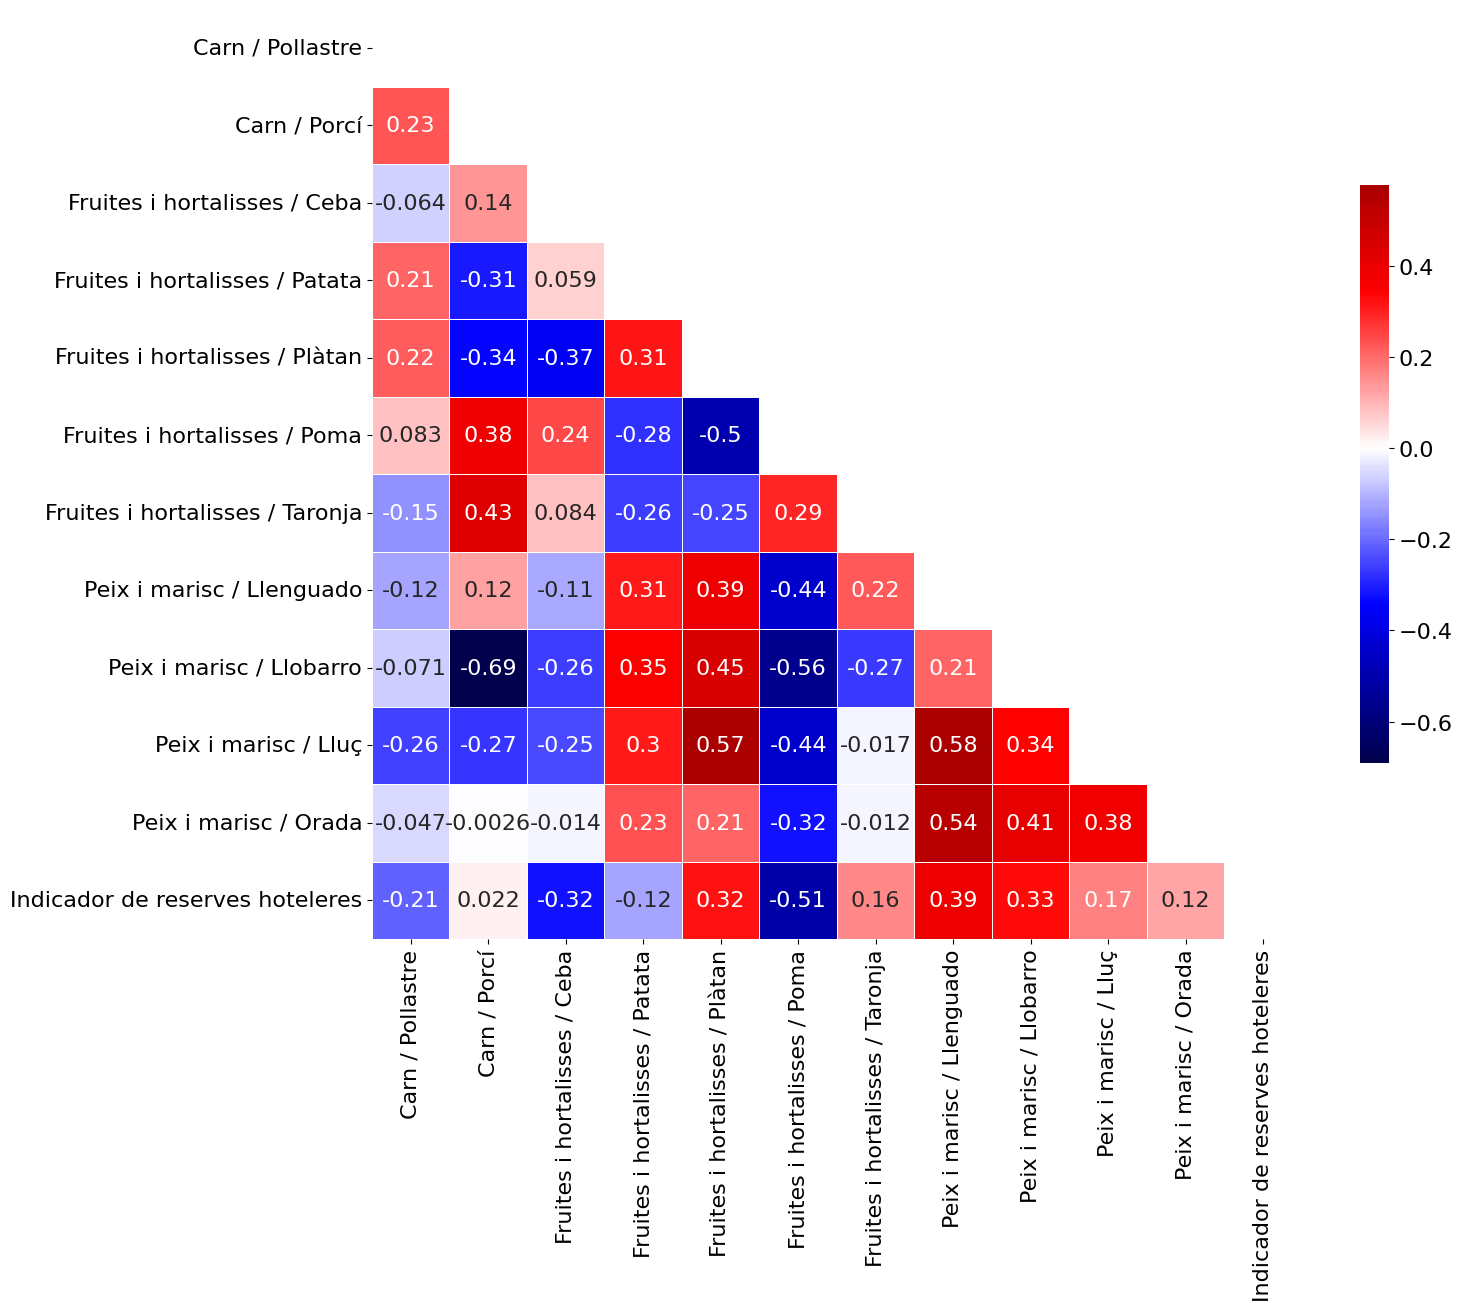

In [6]:
corr = data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True);

Del heatmap podemos observar diferentes correlaciones interesantes entre la variable objetivo y el resto de variables.
Tanto el lenguado, la lubina como el plátano tienen una correlación positiva muy fuerte con el indicador de reservas hoteleras: 0.39, 0.33 y 0.32 respectivamente.
Mientras que la manzana y la cebolla tienen una correlación negativa muy pronunciada: -0.51 y -0.32 respectivamente.
El resto de variables tienen una correlación más débil.

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Apartado B

In [11]:
niter = 50
cv = 5
results = pd.DataFrame()

def save_results(model, X_train, y_train, X_test, y_test, name, df):
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  df.loc[name,'train score'] = r2_score(y_train, y_train_pred)
  df.loc[name,'test score'] = r2_score(y_test, y_test_pred)
  df.loc[name,'cross_val score'] = np.mean(cross_val_score(model, X_train, y_train, cv=cv, scoring='r2'))

  return df

### SVM de regresión con kernel polinómico

In [15]:
param = {
    'C': 10**np.linspace(-3, 3, 101),
    'degree': [2, 3, 4],
    'epsilon': np.linspace(0, 0.1, 11),
    'coef0': np.linspace(0, 1, 11)
}

psvr = SVR(kernel='poly', max_iter=50000, cache_size=2000)
psvr_gs = BayesSearchCV(psvr,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
psvr_gs.fit(X_train, y_train)
show_html(pd.DataFrame(psvr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

BayesSearchCV(cv=5,
              estimator=SVR(cache_size=2000, kernel='poly', max_iter=50000),
              n_jobs=-1, random_state=0,
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-03, 6.91830971...
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'coef0': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                             'degree': [2, 3, 4],
                             'epsilon': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 

,params,mean_test_score,rank_test_score
47,"{'C': 2.6302679918953813, 'coef0': 1.0, 'degree': 2, 'epsilon': 0.05}",0.698,1
35,"{'C': 2.6302679918953813, 'coef0': 0.9, 'degree': 2, 'epsilon': 0.08}",0.697,2
36,"{'C': 2.6302679918953813, 'coef0': 0.9, 'degree': 2, 'epsilon': 0.09}",0.697,3
48,"{'C': 2.6302679918953813, 'coef0': 0.8, 'degree': 2, 'epsilon': 0.08}",0.697,4
46,"{'C': 2.6302679918953813, 'coef0': 0.7000000000000001, 'degree': 2, 'epsilon': 0.08}",0.696,5


In [16]:
results = save_results(psvr_gs, X_train, y_train, X_test, y_test, 'pSVR', results);
results

,train score,test score,cross_val score
pSVR,0.813,0.389,0.678


### SVM de regresión con kernel RBF

In [17]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto'], 'epsilon':np.linspace(0,0.01,11)}

rbsvr =  SVR(kernel='rbf', max_iter=50000, cache_size=2000)
rbsvr_gs = BayesSearchCV(rbsvr,param,n_iter=niter,
                        cv=cv,
                        n_jobs=-1,
                        refit=True, random_state=0)
rbsvr_gs.fit(X_train, y_train);
show_html(pd.DataFrame(rbsvr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

BayesSearchCV(cv=5, estimator=SVR(cache_size=2000, max_iter=50000), n_jobs=-1,
              random_state=0,
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-03, 6.91830971e-03, 7.9432823...
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'epsilon': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 ]),
                             'gamma': ['scale', 'auto']})

,params,mean_test_score,rank_test_score
33,"{'C': 41.68693834703355, 'epsilon': 0.002, 'gamma': 'scale'}",0.747,1
40,"{'C': 436.51583224016565, 'epsilon': 0.005, 'gamma': 'auto'}",0.746,2
31,"{'C': 331.13112148259074, 'epsilon': 0.005, 'gamma': 'auto'}",0.745,3
37,"{'C': 10.471285480508985, 'epsilon': 0.002, 'gamma': 'scale'}",0.742,4
18,"{'C': 190.54607179632444, 'epsilon': 0.007, 'gamma': 'auto'}",0.726,5


In [18]:
results = save_results(rbsvr_gs, X_train, y_train, X_test, y_test, 'rbSVR', results);
results

,train score,test score,cross_val score
pSVR,0.813,0.389,0.678
rbSVR,0.962,0.680,0.773


De la tabla podemos observar que el SVR con kernel RBF (rbSVR) es significativamente más efectivo que el polinómico (pSVR). El rbSVR muestra una alta puntuación en el entrenamiento (0.962), lo que indica una excelente adaptación a los datos de entrenamiento, y mantiene un rendimiento robusto en la prueba (0.680) y en la validación cruzada (0.773). Esto sugiere una buena generalización del modelo a datos no vistos. En contraste, el pSVR, aunque tiene un rendimiento razonable en entrenamiento (0.813), cae drásticamente en el test (0.389), indicando un posible sobreajuste y una mala generalización. La notable diferencia en las puntuaciones de prueba y validación cruzada entre ambos modelos enfatiza la superioridad del rbSVR en manejar la complejidad y la no linealidad de la relación entre los precios de los alimentos y las reservas hoteleras.

### Permutation Importance de SVM RBF


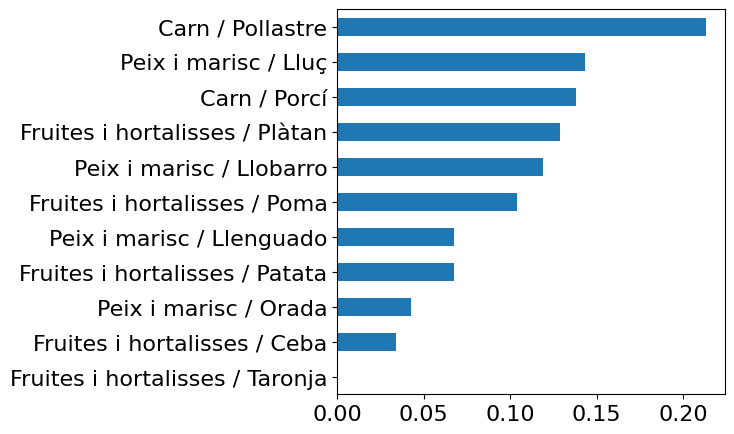

In [20]:
pi = permutation_importance(rbsvr_gs,X_test, y_test.to_numpy(), n_jobs=-1, random_state=0)
feature_names = data.columns[data.columns != 'Indicador de reserves hoteleres']
var_imp_mlp = pd.DataFrame({'importance': pi.importances_mean}, index=feature_names)
var_imp_mlp.sort_values(by='importance').plot.barh(figsize=(5,5), legend=False);

De la gráfica podemos observar que los atributos más importantes para predecir el número de reservas de un hotel son el precio del pollo (con un poco más del 20% de importancia respecto el total), seguido de la merluza, el porcino, la lubina, el lenguado y la manzana. La naranja, por su parte, no tiene ninguna importancia.

## Apartado C

### Random Forest de regresión

In [21]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200],
         'criterion': ['poisson', 'squared_error', 'friedman_mse', 'absolute_error'],
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rf =  RandomForestRegressor(random_state=0)
rf_bs =  BayesSearchCV(rf,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rf_bs.fit(X_train, y_train);
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

BayesSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
              random_state=0,
              search_spaces={'criterion': ['poisson', 'squared_error',
                                           'friedman_mse', 'absolute_error'],
                             'max_depth': [None, 1, 2, 3, 5, 8, 9, 10, 15],
                             'min_samples_leaf': [1, 2, 3, 5, 10],
                             'n_estimators': [5, 10, 25, 40, 50, 75, 100, 200]})

,params,mean_test_score,rank_test_score
18,"{'criterion': 'poisson', 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 40}",0.773,1
19,"{'criterion': 'poisson', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 40}",0.772,2
38,"{'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 40}",0.772,2
13,"{'criterion': 'poisson', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 40}",0.771,4
48,"{'criterion': 'poisson', 'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 40}",0.769,5


In [22]:
results = save_results(rf_bs, X_train, y_train, X_test, y_test, 'RF', results);
results

,train score,test score,cross_val score
pSVR,0.813,0.389,0.678
rbSVR,0.962,0.680,0.773
RF,0.982,0.680,0.746


### Gradient Boosting de regresión

In [23]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200],
         'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
         'criterion':['friedman_mse', 'squared_error'],
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10],
         'learning_rate':[0.01, 0.1, 0.2, 0.5, 1]}

gb =  GradientBoostingRegressor(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train, y_train);
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

BayesSearchCV(cv=5,
              estimator=GradientBoostingRegressor(n_iter_no_change=5,
                                                  random_state=0),
              n_jobs=-1, random_state=0,
              search_spaces={'criterion': ['friedman_mse', 'squared_error'],
                             'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
                             'loss': ['squared_error', 'absolute_error',
                                      'huber', 'quantile'],
                             'max_depth': [None, 1, 2, 3, 5, 8, 9, 10, 15],
                             'min_samples_leaf': [1, 2, 3, 5, 10],
                             'n_estimators': [5, 10, 25, 40, 50, 75, 100, 200]})

,params,mean_test_score,rank_test_score
32,"{'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'absolute_error', 'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 100}",0.792,1
25,"{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'absolute_error', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}",0.785,2
22,"{'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'absolute_error', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}",0.785,2
20,"{'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'absolute_error', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}",0.785,2
38,"{'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'absolute_error', 'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 100}",0.782,5


In [24]:
results = save_results(gb_bs, X_train, y_train, X_test, y_test, 'GB', results);
results

,train score,test score,cross_val score
pSVR,0.813,0.389,0.678
rbSVR,0.962,0.680,0.773
RF,0.982,0.680,0.746
GB,0.976,0.727,0.732


De la tabla podemos observar que ambos modelos tienen un rendimiento parecido, aunque el Gradient Boosting es ligeramente superior, al denotar un menor grado de overfiting y mayor generalización con un una acierto de test del 72'7% respecto al 68% del Random Forest. Esto se puede deber a que GB construye modelos de manera aditiva especializándose en los residuos del modelo anterior, lo que le permite adaptarse más eficientemente a la naturaleza variada de los datos.

### Permutation Importance de GB

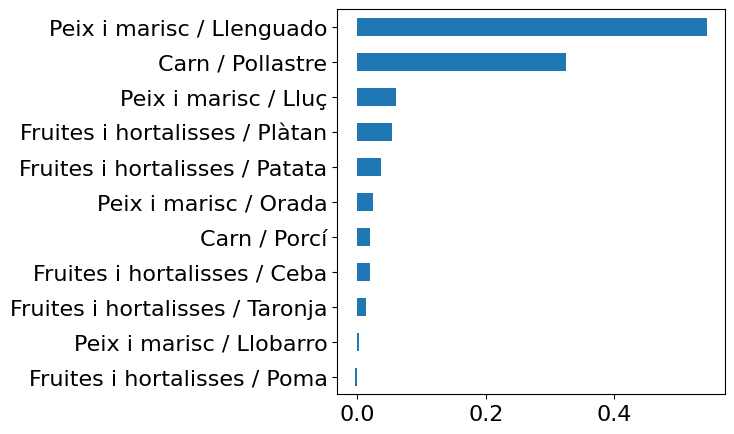

In [25]:
pi = permutation_importance(gb_bs,X_test, y_test.to_numpy(), n_jobs=-1, random_state=0)
feature_names = data.columns[data.columns != 'Indicador de reserves hoteleres']
var_imp_mlp = pd.DataFrame({'importance': pi.importances_mean}, index=feature_names)
var_imp_mlp.sort_values(by='importance').plot.barh(figsize=(5,5), legend=False);

De la gráfica podemos observar que la importancia de los atributos han cambiado bastante respecto al SVM RBF. Ahora el lenguado es sin duda el más importante, seguido del pollo. El resto de variables no tienen casi importancia alguna.

## Apartado D

### StackedRegressor

In [26]:
st = StackingRegressor([('rf', rf_bs.best_estimator_),
                          ('gb', gb_bs.best_estimator_)],
                          cv=cv, n_jobs=1)

st.fit(X_train, y_train);
results = save_results(st, X_train, y_train, X_test, y_test, 'ST', results);

In [27]:
results

,train score,test score,cross_val score
pSVR,0.813,0.389,0.678
rbSVR,0.962,0.680,0.773
RF,0.982,0.680,0.746
GB,0.976,0.727,0.732
ST,0.975,0.729,0.778


Al combinar el Random Forest con el Gradient Boosting en el Stacking Regressor hemos obtenido una mejor puntuación, ligeramente superior a la original de GB, con un acierto de test del 72'9% y cross val del 77'8%.

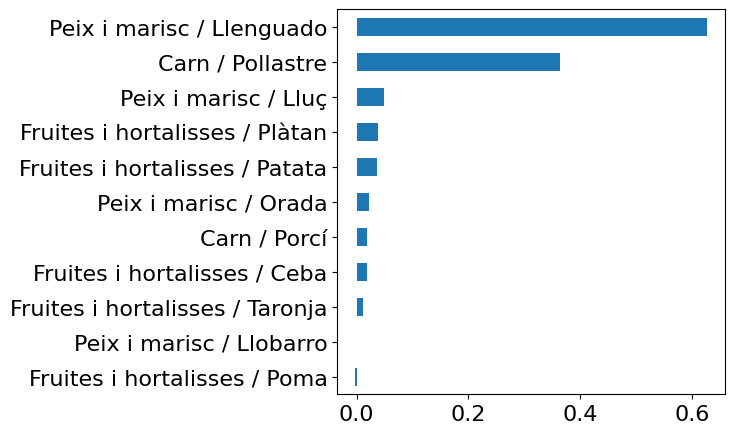

In [28]:
pi = permutation_importance(st,X_test, y_test.to_numpy(), n_jobs=-1, random_state=0)
feature_names = data.columns[data.columns != 'Indicador de reserves hoteleres']
var_imp_mlp = pd.DataFrame({'importance': pi.importances_mean}, index=feature_names)
var_imp_mlp.sort_values(by='importance').plot.barh(figsize=(5,5), legend=False);

Podemos ver que el orden de importancia sigue siendo el mismo que con el Grandient Boosting, aunque la escala ha cambiado ligeramente.

### VotingRegressor

In [29]:
vs = VotingRegressor([('rf', rf_bs.best_estimator_),
                          ('gb', gb_bs.best_estimator_)], n_jobs=1)

vs.fit(X_train, y_train);
results = save_results(vs, X_train, y_train, X_test, y_test, 'VS', results);

In [30]:
results

,train score,test score,cross_val score
pSVR,0.813,0.389,0.678
rbSVR,0.962,0.680,0.773
RF,0.982,0.680,0.746
GB,0.976,0.727,0.732
ST,0.975,0.729,0.778
VS,0.984,0.716,0.794


Al combinar el Random Forest con el Gradient Boosting en el Voting Regressor hemos obtenido una peor puntuación. A pesar de predecir mejor que el RF, no llegamos a superar al GB, quedándonos detrás de él con una acierto de test del 71'6%.

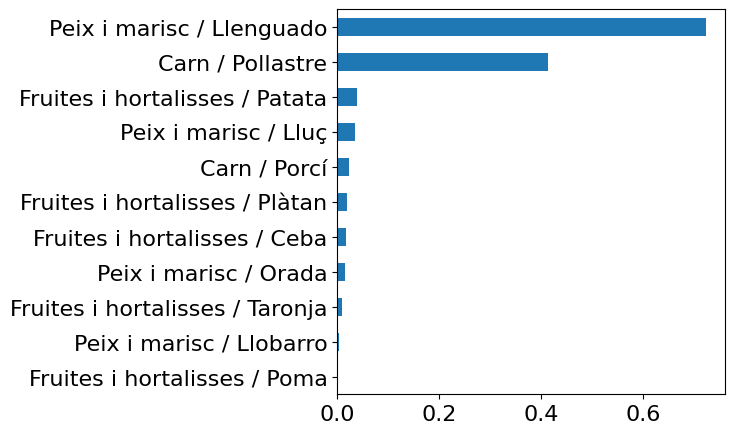

In [31]:
pi = permutation_importance(vs,X_test, y_test.to_numpy(), n_jobs=-1, random_state=0)
feature_names = data.columns[data.columns != 'Indicador de reserves hoteleres']
var_imp_mlp = pd.DataFrame({'importance': pi.importances_mean}, index=feature_names)
var_imp_mlp.sort_values(by='importance').plot.barh(figsize=(5,5), legend=False);

Podemos ver que el orden de importancia se ha modificado ligeramente, siguen estando el lenguado y el pollo en primera posiciones, pero luego pasa de merluza y plátano del GB original a patata y merluza como tercer y cuarto puesto.